In [1]:
pip install -U pandas==1.5.3 # because current version of pandas has problem converting to Spark SQL DF

In [2]:
import findspark
findspark.init()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
from pyspark.mllib.util import MLUtils

In [4]:
generate_random = np.random.RandomState(0)
x = 10 * generate_random.rand(100)

In [5]:
y = 3 * x + np.random.randn(100)

In [6]:
x

array([5.48813504, 7.15189366, 6.02763376, 5.44883183, 4.23654799,
       6.45894113, 4.37587211, 8.91773001, 9.63662761, 3.83441519,
       7.91725038, 5.2889492 , 5.68044561, 9.25596638, 0.71036058,
       0.871293  , 0.20218397, 8.32619846, 7.78156751, 8.70012148,
       9.78618342, 7.99158564, 4.61479362, 7.80529176, 1.18274426,
       6.39921021, 1.43353287, 9.44668917, 5.21848322, 4.1466194 ,
       2.64555612, 7.74233689, 4.56150332, 5.68433949, 0.187898  ,
       6.17635497, 6.12095723, 6.16933997, 9.43748079, 6.81820299,
       3.59507901, 4.37031954, 6.97631196, 0.60225472, 6.66766715,
       6.7063787 , 2.10382561, 1.28926298, 3.15428351, 3.63710771,
       5.7019677 , 4.38601513, 9.88373838, 1.02044811, 2.08876756,
       1.61309518, 6.53108325, 2.53291603, 4.66310773, 2.44425592,
       1.58969584, 1.10375141, 6.56329589, 1.38182951, 1.96582362,
       3.68725171, 8.2099323 , 0.97101276, 8.37944907, 0.96098408,
       9.76459465, 4.68651202, 9.76761088, 6.0484552 , 7.39263

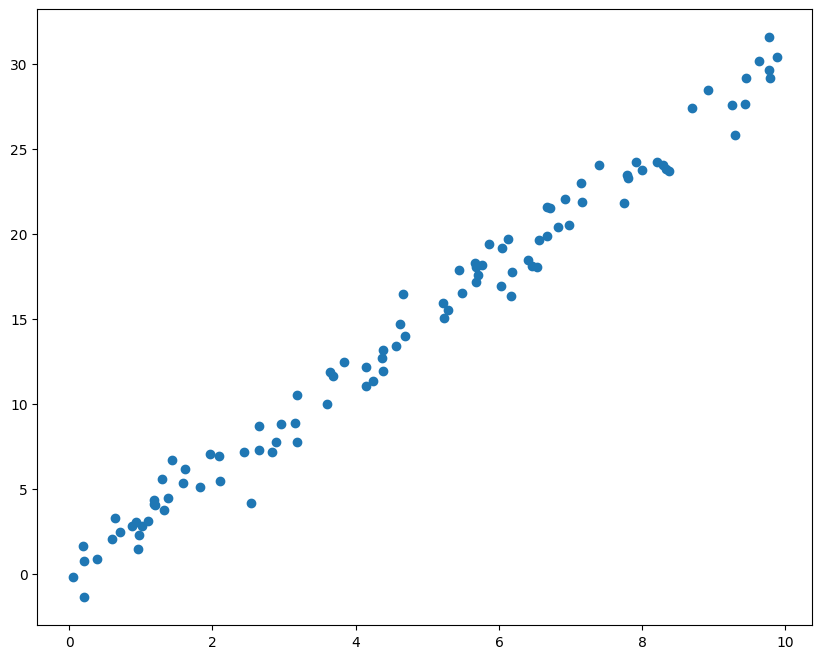

In [7]:
plt.figure(figsize = (10, 8))
plt.scatter(x, y);

In [8]:
frame={'x':list(x),'label':list(y)}
df=pd.DataFrame(frame)

In [9]:
df

,x,label
0,5.488135,16.552132
1,7.151894,22.986816
2,6.027634,16.967792
3,5.448832,17.909167
4,4.236548,11.332776
...,...,...
95,1.831914,5.124720
96,5.865129,19.424731
97,0.201075,-1.381224
98,8.289400,24.076966


In [10]:
spark = SparkSession \
    .builder \
    .appName("LinearRegression") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/18 22:11:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
spdf = spark.createDataFrame(df)

In [11]:
spdf.show()

+------------------+------------------+
|                 x|             label|
+------------------+------------------+
|5.4881350392732475|16.176446488326572|
| 7.151893663724195| 21.70214852962271|
| 6.027633760716439|20.243921366526738|
| 5.448831829968968|15.452696544509626|
| 4.236547993389047|14.226649457807298|
| 6.458941130666561|19.576016200673177|
| 4.375872112626925| 13.25625546854751|
| 8.917730007820797|  27.3600300266367|
| 9.636627605010293|29.258489112766696|
|3.8344151882577773|11.958546511801288|
| 7.917250380826646|23.965791269271584|
| 5.288949197529044| 14.88779605606117|
| 5.680445610939323|16.845527891068947|
|  9.25596638292661| 28.32515020622706|
|0.7103605819788694|1.2285510606489907|
|0.8712929970154071|1.0047517408436815|
|0.2021839744032572|0.4253823396123487|
|  8.32619845547938|26.412956700568735|
| 7.781567509498505|21.596548723252717|
| 8.700121482468191|26.550275472541603|
+------------------+------------------+
only showing top 20 rows



In [12]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['x'], outputCol = 'features')
#vectorAssembler = VectorAssembler(inputCols = ['rm'], outputCol = 'features')
vector_df = vectorAssembler.transform(spdf)
vector_df = vector_df.select(['features', 'label'])
vector_df.show(3)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[5.4881350392732475]|16.176446488326572|
| [7.151893663724195]| 21.70214852962271|
| [6.027633760716439]|20.243921366526738|
+--------------------+------------------+
only showing top 3 rows



In [13]:
splits = vector_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]
print(test_df.count())

33


In [14]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients[0]))
print("Intercept: " + str(lr_model.intercept))

23/05/03 09:43:58 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/03 09:43:58 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
Coefficients: 2.9072364806442743
Intercept: 0.5185205196954595


In [15]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.033658
r2: 0.986361


In [16]:
train_df.describe().show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|                 67|
|   mean| 13.540884771771744|
| stddev|  8.917596852018582|
|    min|-0.5851544942838182|
|    max|   30.6879211406989|
+-------+-------------------+



In [17]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","label","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 16.47382691657274|16.176446488326572|[5.4881350392732475]|
|19.296189801103065|19.576016200673177| [6.458941130666561]|
|21.310766684563074| 21.70214852962271| [7.151893663724195]|
| 26.44447052296823|  27.3600300266367| [8.917730007820797]|
|17.032919226133913|16.845527891068947| [5.680445610939323]|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.989165


In [18]:
y_pred=lr_model.coefficients[0]*x+lr_model.intercept

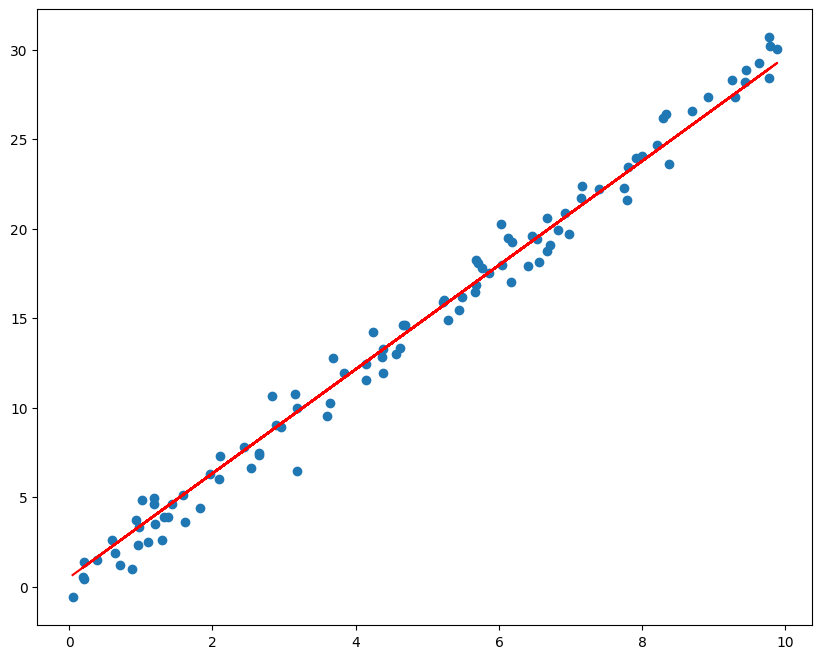

In [19]:
plt.figure(figsize = (10, 8))
plt.scatter(x, y);
plt.plot(x, y_pred,'r-');


In [33]:
lr_predictions.select("features","label","prediction").show(2)

+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[5.4881350392732475]|16.176446488326572| 16.47382691657274|
| [6.458941130666561]|19.576016200673177|19.296189801103065|
+--------------------+------------------+------------------+
only showing top 2 rows



In [40]:
X=[]
for i in lr_predictions.select("features","label","prediction").rdd.map(lambda x: [x[0][0]]).collect():
    X.append(i[0])
L=[]
for i in lr_predictions.select("features","label","prediction").rdd.map(lambda x: [x[1]]).collect():
#    print(i[0])
    L.append(i[0])
P=[]
for i in lr_predictions.select("features","label","prediction").rdd.map(lambda x: [x[2]]).collect():
#    print(i[0])
    P.append(i[0])

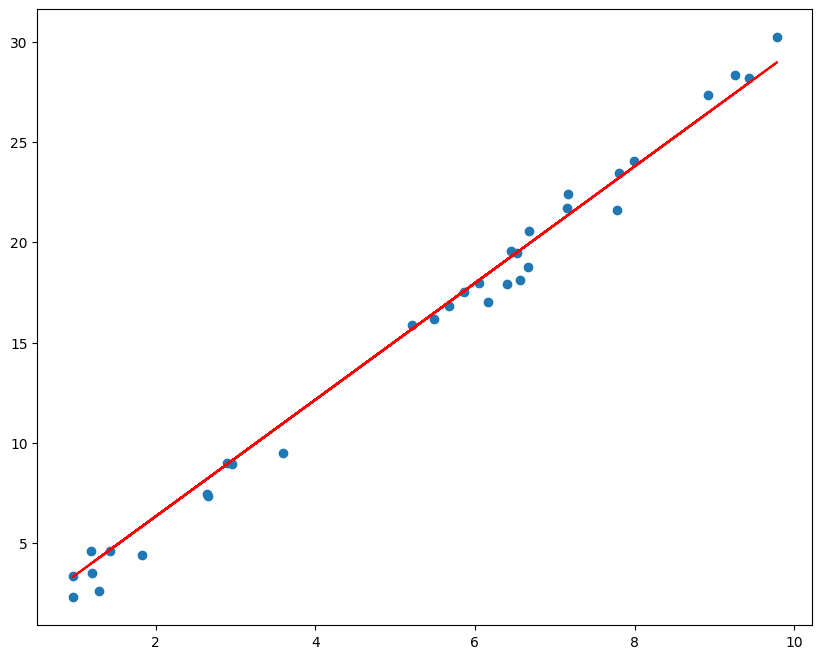

In [41]:
plt.figure(figsize = (10, 8))
plt.scatter(X, L);
plt.plot(X, P,'r-');